In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from collections import Counter

# モデル作成・評価

In [2]:
# 学習データの読み込み
train_df = pd.read_csv("train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
# 欠損値の確認
train_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [4]:
# 欠損値の数を確認
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# ETL処理
def func_ETL(data):
    # 変数の削除
    data = data.drop('PassengerId', axis=1)
    data = data.drop('Name', axis=1)
    data = data.drop('Ticket', axis=1)
    data = data.drop('Cabin', axis=1)

    # 欠損の穴埋め
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

    # 変数の作成
    data['FamilySize'] = data["SibSp"] + data["Parch"] + 1
    data = data.drop("SibSp", axis=1)
    data = data.drop("Parch", axis=1)

    sex_dum = pd.get_dummies(data['Sex'])
    data = pd.concat((data, sex_dum), axis=1)
    data = data.drop('Sex', axis=1)

    emb_dum = pd.get_dummies(data['Embarked'])
    data = pd.concat((data, emb_dum), axis=1)
    data = data.drop('Embarked', axis=1)

    # 相関の確認
    data.corr()
    
    return data

In [6]:
# ETL処理
train = func_ETL(train_df)

In [7]:
# 相関の確認
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


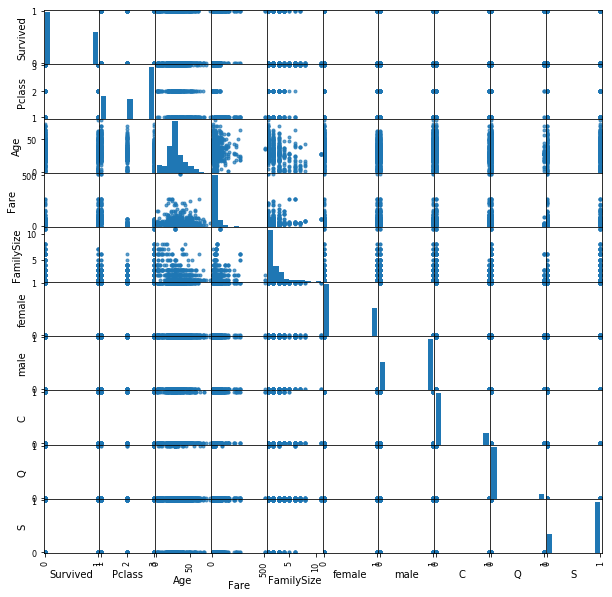

In [8]:
# 変数の相関性確認
pd.tools.plotting.scatter_matrix(train, alpha=0.7, figsize=(10,10))
plt.show()

In [9]:
# 欠損の確認
train.isnull().sum()

Survived      0
Pclass        0
Age           0
Fare          0
FamilySize    0
female        0
male          0
C             0
Q             0
S             0
dtype: int64

In [10]:
# データの整形
train_data = train.values

# 訓練データ
x_train = train_data[:int(len(train)*0.8),1:]
y_train = train_data[:int(len(train)*0.8),0]

# テストデータ
x_test = train_data[int(len(train)*0.8):,1:]
y_test = train_data[int(len(train)*0.8):,0]

In [11]:
# Pipeline作成
estimators = [('svm', svm.SVC())]
pl = Pipeline(estimators)

In [ ]:
# パラメータ1
'''
parameters = {
    "svm__kernel" : ["linear","rbf"],
    'svm__C': np.logspace(0, 2, 2).tolist(),
    "svm__gamma": np.logspace(-3, 0, 2).tolist()
}
'''

In [16]:
# パラメータ2
'''
parameters = [
    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
    {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}
]
'''

In [ ]:
# パラメータ3
parameters = [
    {'svm__C': [1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]}
]

In [17]:
# モデル作成
clf = GridSearchCV(pl, parameters, n_jobs=-1)
clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']}, {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]}, {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]}, {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
# 各試行のスコア
clf.grid_scores_

/Users/yasu/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.78371, std: 0.02078, params: {'svm__C': 1, 'svm__kernel': 'linear'},
 mean: 0.78371, std: 0.02078, params: {'svm__C': 10, 'svm__kernel': 'linear'},
 mean: 0.78230, std: 0.01986, params: {'svm__C': 100, 'svm__kernel': 'linear'},
 mean: 0.78511, std: 0.00691, params: {'svm__C': 1000, 'svm__kernel': 'linear'},
 mean: 0.66292, std: 0.04584, params: {'svm__C': 1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'},
 mean: 0.64747, std: 0.04059, params: {'svm__C': 1, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'},
 mean: 0.73596, std: 0.05481, params: {'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'},
 mean: 0.66011, std: 0.03728, params: {'svm__C': 10, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'},
 mean: 0.77247, std: 0.01554, params: {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'},
 mean: 0.76264, std: 0.01810, params: {'svm__C': 100, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'},
 mean: 0.77809, std: 0.02736, params: {'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

In [20]:
# 最適化したパラメータ
clf.best_estimator_.get_params()

{'steps': [('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape=None, degree=2, gamma=0.001, kernel='poly',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))],
 'svm': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=2, gamma=0.001, kernel='poly',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'svm__C': 100,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': None,
 'svm__degree': 2,
 'svm__gamma': 0.001,
 'svm__kernel': 'poly',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state': None,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [21]:
# テストデータで評価
output = clf.predict(x_test)
accuracy_score(output, y_test)

0.86033519553072624

# 問題データによる判定

In [25]:
# 問題データの読み込み
question_df = pd.read_csv("question.csv")

# 問題データのETL
question = func_ETL(question_df)

# 問題データの整形
question_data = question.values

In [26]:
# 予測
output = clf.predict(question_data)

In [28]:
question_df["Survived"] = output
question_df[["PassengerId","Survived"]].to_csv("./output/submission.csv",index=False)